In [50]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [146]:
metric_labeller <- as_labeller(c(
    "RL_F_idk" = "RL (F)",
    "RB_agg_idk" = "RB (alg)",
    "RB_llm_idk" = "RB (llm)"
))

# baselines

# A tibble: 36 × 4
   Model     metric     retrieved value
   <fct>     <fct>      <fct>     <dbl>
 1 Reference RL_F_idk   Ref        0.86
 2 Reference RL_F_idk   Mix        0.87
 3 Reference RL_F_idk   RAG        0.67
 4 Reference RB_llm_idk Ref        0.94
 5 Reference RB_llm_idk Mix        0.94
 6 Reference RB_llm_idk RAG        0.94
 7 Reference RB_agg_idk Ref        0.88
 8 Reference RB_agg_idk Mix        0.88
 9 Reference RB_agg_idk RAG        0.86
10 GPT-4o    RL_F_idk   Ref        0.69
# ℹ 26 more rows
# A tibble: 3 × 2
  metric     value
  <fct>      <dbl>
1 RL_F_idk    0.53
2 RB_llm_idk  0.54
3 RB_agg_idk  0.34


Saving 6.67 x 6.67 in image


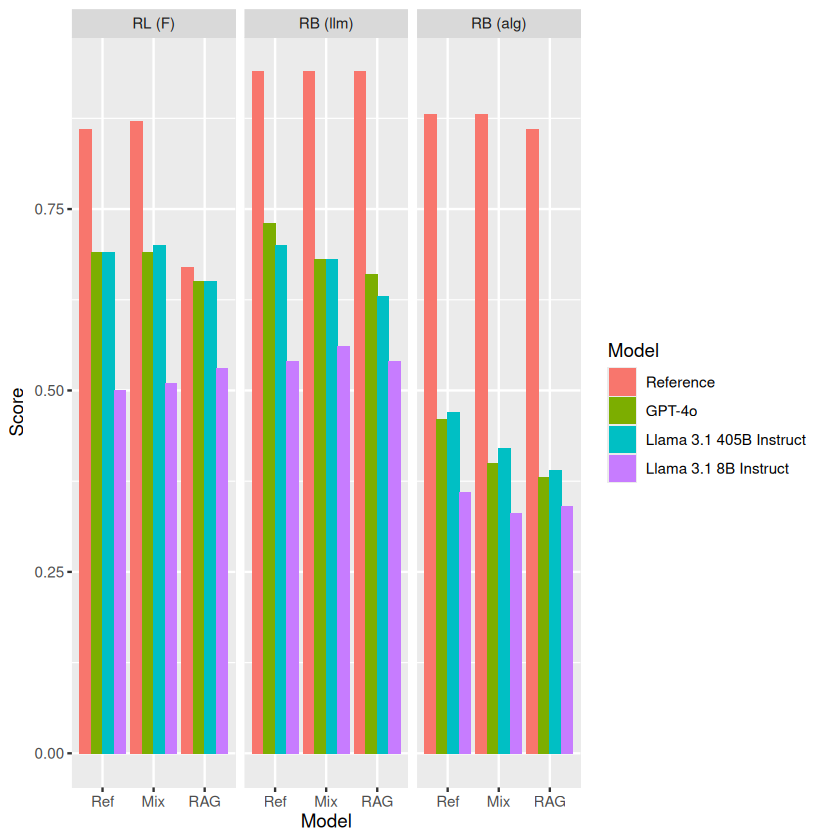

In [167]:
baselines <- read.table(text = '
"Model" "Acc Ref" "Acc Mix" "Acc RAG" "RL_F Ref" "RL_F Mix" "RL_F RAG" "RB_llm Ref" "RB_llm Mix" "RB_llm RAG" "RB_alg Ref" "RB_alg Mix" "RB_alg RAG"
"Reference" 0.98 0.97 0.98 0.86 0.87 0.67 0.94 0.94 0.94 0.88 0.88 0.86
"Command-R+ (104B)" 0.86 0.86 0.87 0.69 0.71 0.66 0.66 0.62 0.59 0.43 0.40 0.38
"GPT-4o" 0.89 0.86 0.86 0.69 0.69 0.65 0.73 0.68 0.66 0.46 0.40 0.38
"GPT-4o-mini" 0.87 0.86 0.84 0.66 0.69 0.64 0.72 0.68 0.64 0.43 0.40 0.37
"Llama 3.1 405B Instruct" 0.87 0.86 0.85 0.69 0.70 0.65 0.70 0.68 0.63 0.47 0.42 0.39
"Llama 3.1 70B Instruct" 0.78 0.83 0.81 0.63 0.66 0.64 0.62 0.64 0.59 0.43 0.42 0.39
"Llama 3.1 8B Instruct" 0.71 0.75 0.74 0.50 0.51 0.53 0.54 0.56 0.54 0.36 0.33 0.34
"Mixtral 8x22B Instruct" 0.86 0.87 0.86 0.54 0.61 0.56 0.66 0.64 0.61 0.39 0.38 0.35
"Qwen 2.5 (72B)" 0.87 0.87 0.87 0.65 0.71 0.64 0.71 0.69 0.65 0.43 0.40 0.37
"Qwen 2.5 (7B)" 0.88 0.86 0.87 0.62 0.66 0.62 0.68 0.65 0.63 0.42 0.38 0.37
', header = TRUE)[c(1,3,5,7),] %>% select(-contains("Acc"))

baselines <- pivot_longer(baselines, cols = !"Model", names_sep = "\\.", names_to = c("metric", "retrieved"))
baselines$metric <- factor(baselines$metric, levels=c("RL_F", "RB_llm", "RB_alg"), labels=c("RL_F_idk", "RB_llm_idk", "RB_agg_idk"))
baselines$Model <- factor(baselines$Model, levels=c("Reference", "GPT-4o", "Llama 3.1 405B Instruct", "Llama 3.1 8B Instruct"))
baselines$retrieved <- factor(baselines$retrieved, levels=c("Ref", "Mix", "RAG"))
print(baselines)

baselines_rag <- baselines[baselines$retrieved=="RAG",]
baselines_llama <- baselines_rag[baselines_rag$Model == "Llama 3.1 8B Instruct", c("metric", "value")]
baselines_gpt4 <- baselines_rag[baselines_rag$Model == "GPT-4o", c("metric", "value")]
print(baselines_llama)

p <- ggplot(baselines, aes(fill = Model, x = retrieved, y = value)) +
    geom_bar(position="dodge", stat="identity") +
    facet_wrap(~metric, labeller=metric_labeller) + xlab("Model") + ylab("Score")
print(p)
ggsave("plots/baselines.png", p)

# results

## answerability

In [148]:
ans_metrics <- Sys.glob("/blue/cis6930/team7/CIS6930_T7_MTRAG/metrics/answerability*.csv")

Saving 6.67 x 6.67 in image


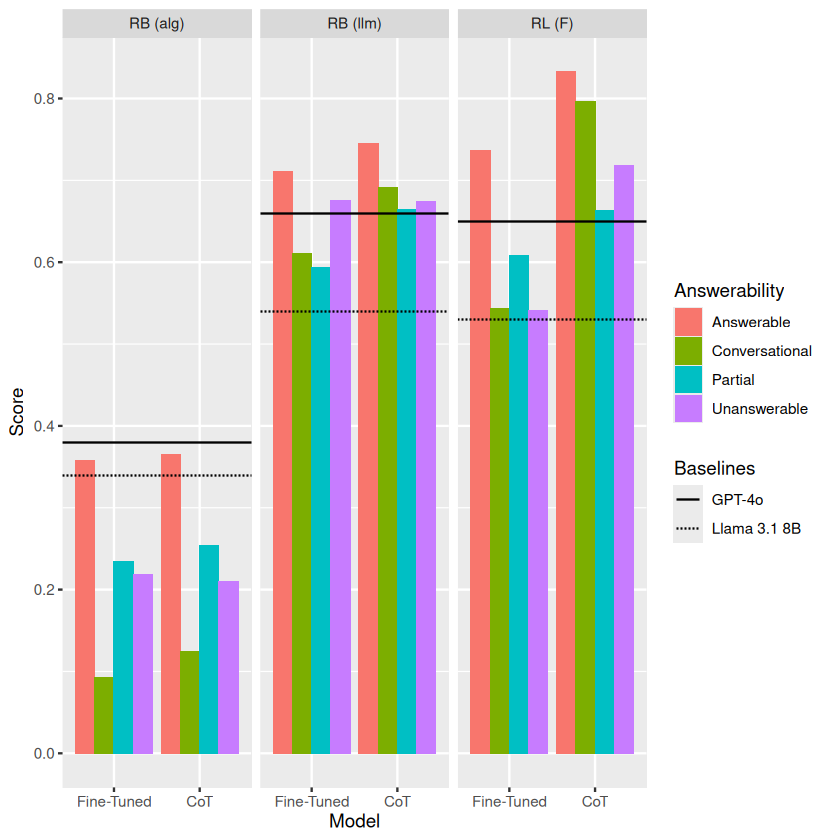

In [214]:
answerability <- data.frame()

for (metric in ans_metrics) {
    match <- str_match(basename(metric), "Meta-Llama-3.1-8B(.*)_raft_(.*)_cot_(.*).csv")

    d <- read_csv(metric, show_col_types = FALSE)
    d <- pivot_longer(d, cols = c("RL_F_idk", "RB_agg_idk", "RB_llm_idk"), names_to = "metric")
    answerability <- rbind(answerability, cbind(
        d,
        instruct = match[2] == "-Instruct",
        raft = match[3],
        cot = factor(ifelse(match[4] == "1", "CoT", "Fine-Tuned"), levels=c("Fine-Tuned", "CoT"))
    ))
}

answerability$Answerability <- str_to_title(answerability$Answerability)
# print(answerability)

p <- ggplot(answerability, aes(fill = Answerability, x = cot, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) + xlab("Model") + ylab("Score") +
    labs(linetype="Baselines")
print(p)
ggsave("plots/answerability.png", p)

## domain

In [151]:
dom_metrics <- Sys.glob("/blue/cis6930/team7/CIS6930_T7_MTRAG/metrics/domain*.csv")

Saving 6.67 x 6.67 in image


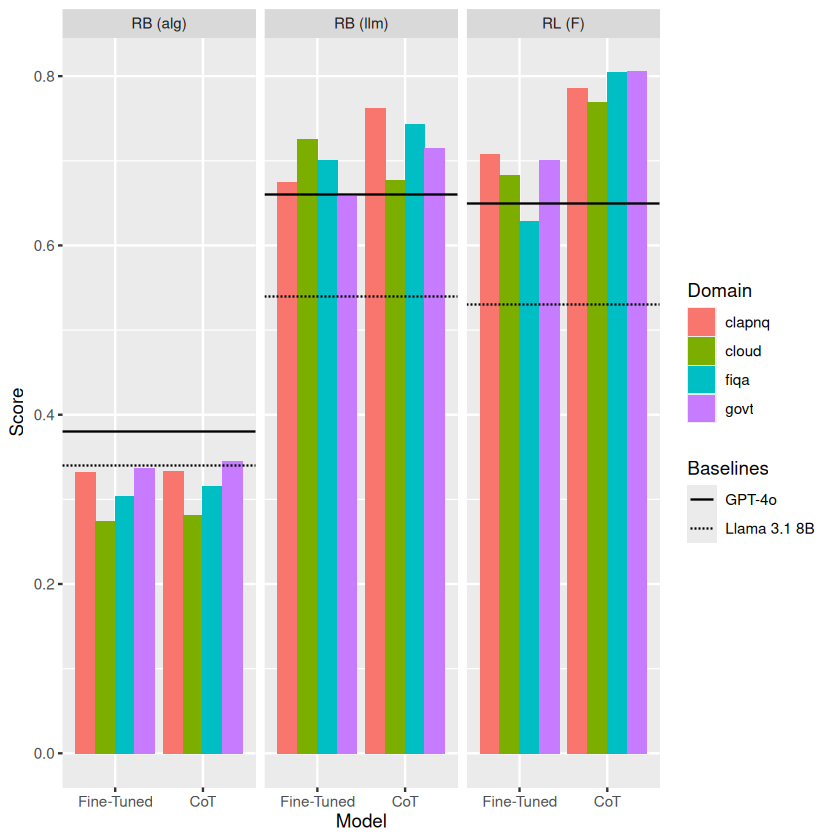

In [213]:
domain <- data.frame()

for (metric in dom_metrics) {
    match <- str_match(basename(metric), "Meta-Llama-3.1-8B(.*)_raft_(.*)_cot_(.*).csv")

    d <- read_csv(metric, show_col_types = FALSE)
    d <- pivot_longer(d, cols = c("RL_F_idk", "RB_agg_idk", "RB_llm_idk"), names_to = "metric")
    domain <- rbind(domain, cbind(
        d,
        instruct = match[2] == "-Instruct",
        raft = match[3],
        cot = factor(ifelse(match[4] == "1", "CoT", "Fine-Tuned"), levels=c("Fine-Tuned", "CoT"))
    ))
}

# print(domain)

p <- ggplot(domain, aes(fill = domain, x = cot, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) +
    labs(x = "Model", y = "Score", fill = "Domain", linetype="Baselines")
print(p)
ggsave("plots/domain.png", p)

## mturn

In [153]:
mt_metrics <- Sys.glob("/blue/cis6930/team7/CIS6930_T7_MTRAG/metrics/mturn*.csv")

Saving 6.67 x 6.67 in image


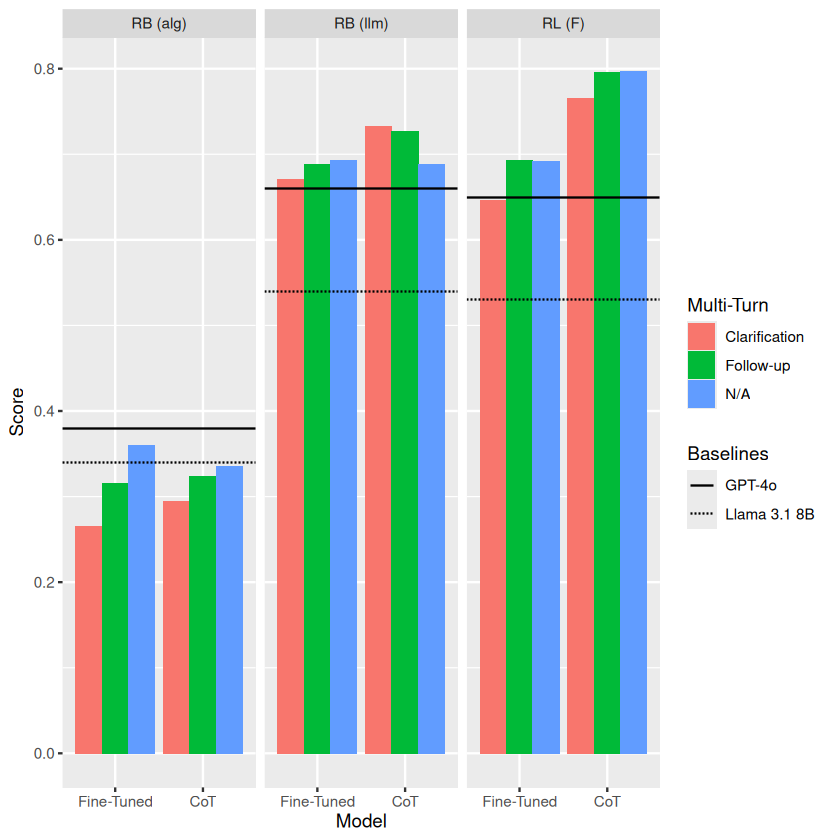

In [212]:
mt <- data.frame()

for (metric in mt_metrics) {
    match <- str_match(basename(metric), "Meta-Llama-3.1-8B(.*)_raft_(.*)_cot_(.*).csv")

    d <- read_csv(metric, show_col_types = FALSE)
    d <- pivot_longer(d, cols = c("RL_F_idk", "RB_agg_idk", "RB_llm_idk"), names_to = "metric")
    mt <- rbind(mt, cbind(
        d,
        instruct = match[2] == "-Instruct",
        raft = match[3],
        cot = factor(ifelse(match[4] == "1", "CoT", "Fine-Tuned"), levels=c("Fine-Tuned", "CoT"))
    ))
}

# print(mt)

p <- ggplot(mt, aes(fill = `Multi-Turn`, x = cot, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) + xlab("Model") + ylab("Score") +
    labs(linetype="Baselines")
print(p)
ggsave("plots/mturn.png", p)

## qntype

In [155]:
qn_metrics <- Sys.glob("/blue/cis6930/team7/CIS6930_T7_MTRAG/metrics/qntype*.csv")

Saving 6.67 x 6.67 in image


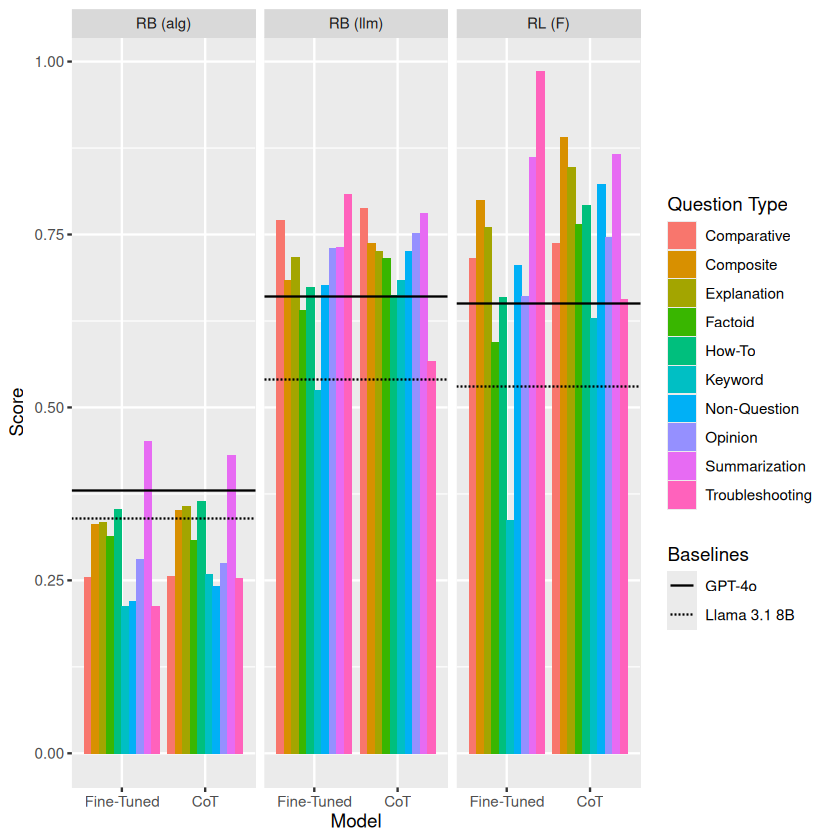

In [211]:
qn <- data.frame()

for (metric in qn_metrics) {
    match <- str_match(basename(metric), "Meta-Llama-3.1-8B(.*)_raft_(.*)_cot_(.*).csv")

    d <- read_csv(metric, show_col_types = FALSE)
    d <- pivot_longer(d, cols = c("RL_F_idk", "RB_agg_idk", "RB_llm_idk"), names_to = "metric")
    qn <- rbind(qn, cbind(
        d,
        instruct = match[2] == "-Instruct",
        raft = match[3],
        cot = factor(ifelse(match[4] == "1", "CoT", "Fine-Tuned"), levels=c("Fine-Tuned", "CoT"))
    ))
}

# print(qn)

p <- ggplot(qn, aes(fill = `Question Type`, x = cot, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) + xlab("Model") + ylab("Score") +
    labs(linetype="Baselines")
print(p)
ggsave("plots/qn.png", p)

## overall

       metric     value instruct raft        cot
1    RL_F_idk 0.6660403 Instruct    0 Fine-Tuned
2  RB_agg_idk 0.3214936 Instruct    0 Fine-Tuned
3  RB_llm_idk 0.6843373 Instruct    0 Fine-Tuned
4    RL_F_idk 0.8000832 Instruct    0        CoT
5  RB_agg_idk 0.3202870 Instruct    0        CoT
6  RB_llm_idk 0.7457831 Instruct    0        CoT
7    RL_F_idk 0.7607949 Instruct    3 Fine-Tuned
8  RB_agg_idk 0.3451537 Instruct    3 Fine-Tuned
9  RB_llm_idk 0.7289157 Instruct    3 Fine-Tuned
10   RL_F_idk 0.7549958 Instruct    3        CoT
11 RB_agg_idk 0.3182826 Instruct    3        CoT
12 RB_llm_idk 0.7337349 Instruct    3        CoT
13   RL_F_idk 0.7142162 Instruct    6 Fine-Tuned
14 RB_agg_idk 0.2984815 Instruct    6 Fine-Tuned
15 RB_llm_idk 0.6831325 Instruct    6 Fine-Tuned
16   RL_F_idk 0.7597437 Instruct    6        CoT
17 RB_agg_idk 0.3160971 Instruct    6        CoT
18 RB_llm_idk 0.7228916 Instruct    6        CoT
19   RL_F_idk 0.7638694     Base    0 Fine-Tuned
20 RB_agg_idk 0.3472

Saving 6.67 x 6.67 in image


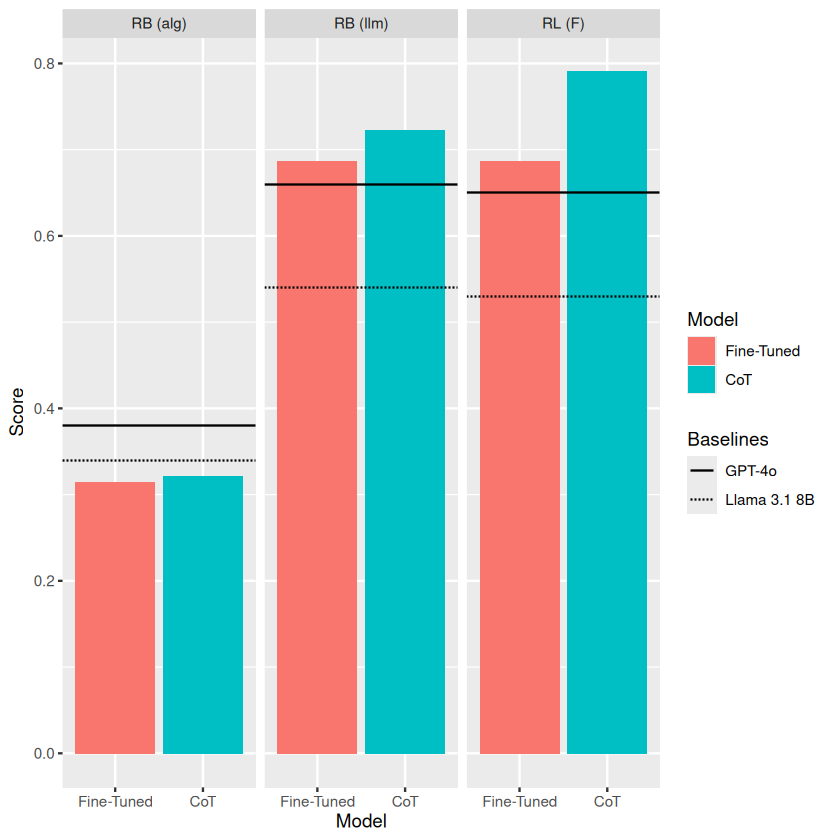

In [222]:
overall_metrics <- Sys.glob("/blue/cis6930/team7/CIS6930_T7_MTRAG/metrics/overall*.csv")

overall <- data.frame()

for (metric in overall_metrics) {
    match <- str_match(basename(metric), "Meta-Llama-3.1-8B(.*)_raft_(.*)_cot_(.*).csv")

    d <- read_csv(metric, show_col_types = FALSE)
    d <- data.frame(
        metric = c("RL_F_idk", "RB_agg_idk", "RB_llm_idk"),
        value = d$`0`
    )
    # print(d)
    # d <- pivot_longer(d, cols = c("RL_F_idk", "RB_agg_idk", "RB_llm_idk"), names_to = "metric")
    overall <- rbind(overall, cbind(
        d,
        instruct = ifelse(match[2] == "-Instruct", "Instruct", "Base"),
        raft = match[3],
        cot = factor(ifelse(match[4] == "1", "CoT", "Fine-Tuned"), levels=c("Fine-Tuned", "CoT"))
    ))
}

print(overall)

p <- ggplot(overall, aes(fill = cot, x = cot, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) +
    labs(x = "Model", y = "Score", fill = "Model", linetype="Baselines")
print(p)
ggsave("plots/overall.png", p)

Saving 6.67 x 6.67 in image


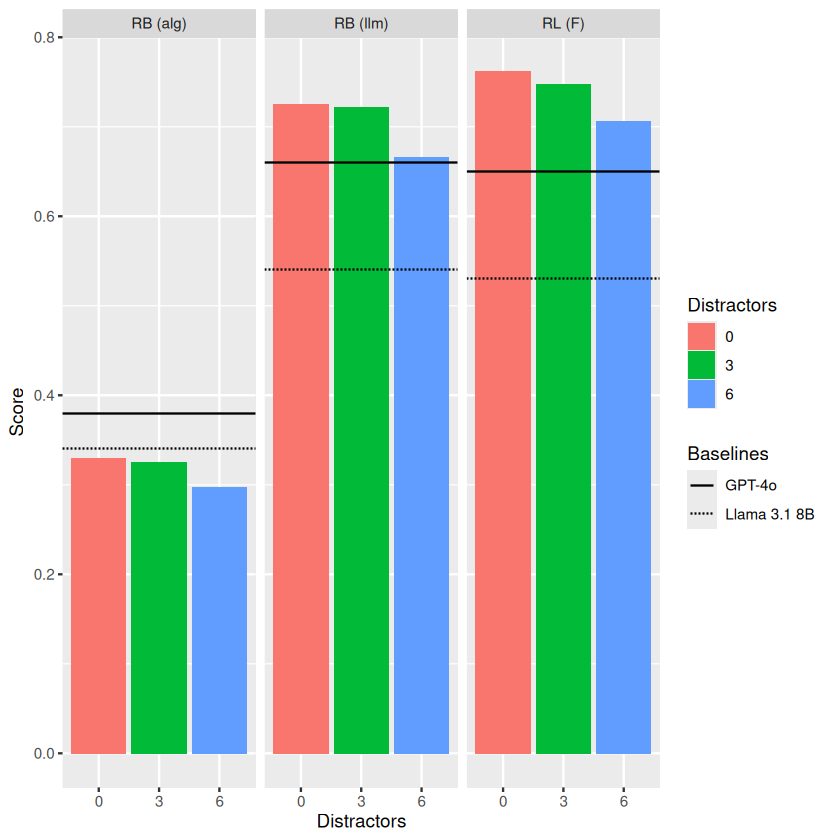

In [230]:
p <- ggplot(overall, aes(fill = raft, x = raft, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) +
    labs(x = "Distractors", y = "Score", fill = "Distractors", linetype="Baselines")
print(p)
ggsave("plots/raft.png", p)

Saving 6.67 x 6.67 in image


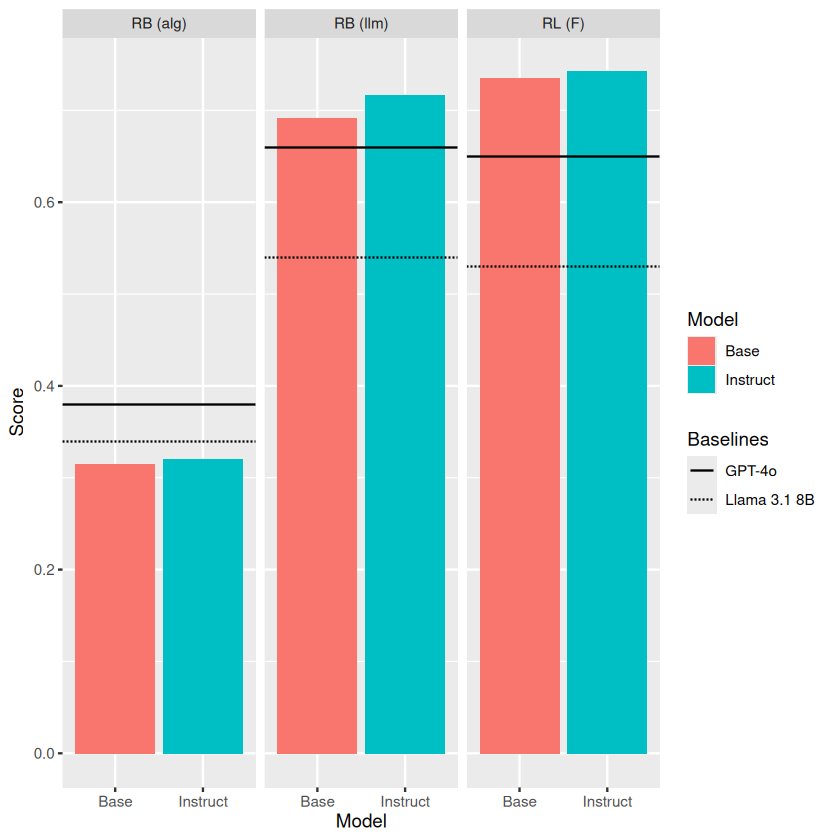

In [229]:
p <- ggplot(overall, aes(fill = instruct, x = instruct, y = value)) +
    geom_bar(position="dodge", stat="summary", fun="mean") +
    geom_hline(data=baselines_llama, aes(yintercept=value, linetype = "Llama 3.1 8B")) +
    geom_hline(data=baselines_gpt4, aes(yintercept=value, linetype = "GPT-4o")) +
    facet_wrap(~metric, labeller=metric_labeller) +
    labs(x = "Model", y = "Score", fill = "Model", linetype="Baselines")
print(p)
ggsave("plots/instruct.png", p)